In [1]:
from src.topology.node import Node
from src.protocol import Protocol
from src.message import Message
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel, QuantumChannel
from src.components.detector import PulseDetector
from src.components.light_source import ParametricSource
from src.kernel.event import Event
from src.kernel.process import Process
from enum import Enum, auto
from matplotlib import pyplot as plt

class MsgType(Enum):
    STOP = auto()

tl = Timeline(1e12)

In [2]:
class RamanTestSender(Protocol):
    def __init__(self, own: Node):
        self.own = own
        # own.protocols.append(self)
        # self.other_nodes = other_nodes

    def start(self):
        # self.own.qchannels[self.own.signal_receiver].start_clock()

        for i in range(1000):
            temp_time = self.emit_event()
            if not temp_time == None:
                emit_time = temp_time

        new_msg = Message(MsgType.STOP, self.own.signal_receiver)

        # print(f"emission stopped at: {emit_time}, stop signal sent at {emit_time + 20}")

        process = Process(self.own, "send_message", [self.own.signal_receiver, new_msg])
        event = Event(emit_time + 2000, process)
        self.own.timeline.schedule(event)
        # self.own.send_message(self.own.signal_receiver, new_msg)

    def emit_event(self):
        # print("a photon was emitted")
        return self.own.parametric_source.emit()

    def received_message(self, src: str, message: Message):
        pass


class RamanTestReceiver(Protocol):
    def __init__(self, signal_node, idler_node, other_node: str):
        # signal_node.protocols.append(self)
        # idler_node.protocols.append(self)
        self.signal_node = signal_node
        self.idler_node = idler_node
        self.other_node = other_node
        self.first_detection = True
        self.first_detection_time = 0
        self.detection_times = []
        self.first_signal = False
        self.stop_receiving = False

    def start(self):
        # start clock and emissions
        pass

    def trigger(self, receiving_node_detector, time_dict):

        if self.stop_receiving:
            return
        
        detection_time = time_dict['time']
        
        # print(f"Received_detection at {detection_time}")

        receiving_node = receiving_node_detector.own
        # print(f"Receiver trigger function by node: {receiving_node} with signal: {self.signal_node}")
        
        if receiving_node == self.signal_node:
            # print("photon received at signal node")
            if self.first_detection == True:
                # print("first photon detection at signal")
                self.first_detection = False
                self.first_detection_time = detection_time
                self.first_signal = True

            if self.first_detection == False:
                if self.first_signal:
                    # print("second photon also signal, discrading first")
                    self.first_detection_time = detection_time
                else:
                    # print(f"second photon signal, recoding time: {-(detection_time - self.first_detection_time)}")
                    self.first_detection = True
                    self.detection_times.append(-(detection_time - self.first_detection_time))
        
        if receiving_node == self.idler_node:
            # print("photon received at idler node")
            if self.first_detection == True:
                # print("First photon detection at idler")
                self.first_detection = False
                self.first_detection_time = detection_time
                self.first_signal = False

            if self.first_detection == False:
                if not self.first_signal:
                    # print("second photon also idler, discrading first")
                    self.first_detection_time = detection_time
                else:
                    # print(f"second photon signal, recoding time: {detection_time - self.first_detection_time}")
                    self.first_detection = True
                    self.detection_times.append(detection_time - self.first_detection_time)
            
    
    def received_message(self, src: str, message: Message):
        assert message.msg_type == MsgType.STOP
        self.stop_receiving = True

        n, bins, patches = plt.hist(self.detection_times, range(-28125, 28126, 625))
        plt.show()

        

In [3]:
class receiver_node(Node):
    def __init__(self, name, timeline, sender_name):
        Node.__init__(self, name, timeline)
        self.detector = PulseDetector(self, name, timeline)
        self.detector.owner = self
    
    def attach_detector_to_receiver(self, protocol):
        self.detector.attach(protocol)
        self.protocol = protocol

    def receive_message(self, src: str, msg: "Message"):
        self.protocol.received_message(src, msg)

    def receive_qubit(self, src, qubit):
        self.detector.get(qubit)

class sender_node(Node):
    def __init__(self, name, timeline):
        Node.__init__(self, name, timeline)
        self.protocol = RamanTestSender(self)


    def attach_lightsource_to_receivers(self, signal_receiver, idler_receiver):
        self.parametric_source = ParametricSource(own = self, name = None, timeline = self.timeline, signal_receiver=signal_receiver, idler_receiver=idler_receiver)
        self.signal_receiver = signal_receiver
        self.idler_receiver = idler_receiver
        # self.parametric_source.own = self
        # self.spdc_source.attach(self.protocol)

In [4]:
sender = sender_node("sender", tl)
signal_receiver = receiver_node("signal_receiver", tl, 'sender')
idler_receiver = receiver_node("idler_receiver", tl, 'sender')

In [5]:
receiver_protocol = RamanTestReceiver(signal_receiver, idler_receiver, 'sender')

signal_receiver.attach_detector_to_receiver(receiver_protocol)
idler_receiver.attach_detector_to_receiver(receiver_protocol)
sender.attach_lightsource_to_receivers("signal_receiver", "idler_receiver")

In [6]:
import traceback
import sys
try:
    signal_channel = QuantumChannel(name = "signal_channel", timeline = tl, attenuation = 0.076, distance = 5)
    idler_channel = QuantumChannel(name = "idler_channel", timeline = tl, attenuation = 0.076, distance = 5)
    classical_channel = ClassicalChannel(name = "classical_channel", timeline = tl, distance = 5)
    signal_channel.set_ends(sender, "signal_receiver")
    idler_channel.set_ends(sender, "idler_receiver")
    classical_channel.set_ends(sender, "signal_receiver")
except Exception:
    print(traceback.format_exc())

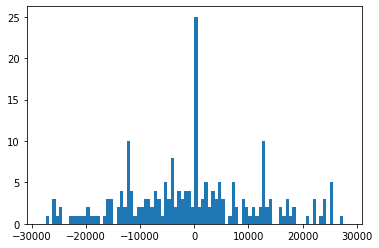

KeyboardInterrupt: 

In [7]:
try:
    process = Process(sender.protocol, "start", [])
    event = Event(0, process)
    tl.schedule(event)

    tl.init()
    tl.run()

    print(signal_receiver.protocol.detection_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show()    
except Exception:
    print(traceback.format_exc())

In [ ]:
list(range(-28125, 28126, 6250))

[-28125, -21875, -15625, -9375, -3125, 3125, 9375, 15625, 21875, 28125]

In [ ]:
import numpy as np

light_speed = 2 * 10**8
optical_wavelength = 1536
clock_power = 0.0003
raman_coefficient = 4.6 * 10**(-10)
narrow_band_filter_bandwidth = 1*10**(-6)
clock_attenuation = 0.099
h = 6.62607015 * 10**(-28)
attenuation = 0.076
raman_power = np.abs(clock_power * raman_coefficient * narrow_band_filter_bandwidth * (np.exp(-attenuation * 5) - np.exp(-clock_attenuation * 5)) / (attenuation - clock_attenuation))

num_photons_added = raman_power / (h * light_speed / optical_wavelength)
print(num_photons_added)
# print("random_times:", np.floor(1e12*np.random.rand(5)))
# np.floor((5 * np.random.rand(5) / (3 * 10**5)) * 1e12)
np.floor(1e12*np.random.rand(5))


5166.420292564249


array([2.68721511e+11, 4.32074567e+11, 2.80921120e+11, 9.81621630e+11,
       2.94179115e+09])